# openshift-ci: build logs initial data collection and EDA

Automated log analysis normally relies on some treats that typical logs exhibit:

- Similar messages are repeated over and over.
- Messages are short, and contain mixed text and parameters.
- Log files contain some structure (time stamps, severity levels, system/component identifiers) as well as *free form* textual data.

Log files from OpenShift CI do not always have these characteristics. A single log file can contain a wide diverstity of log entries, some of which can be long multi-line sequences (e.g. command output) and do not always have the same structure. Moreover, the content type, structure and format varies between jobs, even between executions of the same job over time.

On the other hand, CI logs offer other characteristics that traditional logs often don't:

- Diversity of content (as explained above).
- They have a *beginning* and and *end*.
- We have repetitions at a whole log file level. I.e. the same job runs multiple times, which enables us to compare multiple versions of the same log file (in contrast with traditional log analysis, which can exploit multiple occurrences only at the log entry level).

Different jobs in OpenShif CI provide different log files and outputs, but there is one specific log output that they all have in common: the job's *build log* (`build-log.txt`). We start the log exploration with this type of log.


## Download build log data

We start by accessing job log data. Initially we will get:

- Build logs (`build-log.txt`) for jobs
- Basic metadata about each build log:
  - Size (lenght) of the build log file
  - Duration of the job run
  - The result of the job, i.e. wether the log corresponds to a failed or passed execution
  
All that information is available in a Google Storage bucket called `openshift-ci`. Within that bucket, each CI job definition has matching *prefixes* for its generated artifacts.

For example, all the builds for the job `release-openshift-ocp-installer-e2e-aws-serial-4.7` have the form:

    /logs/release-openshift-ocp-installer-e2e-aws-serial-4.7/BUILD_ID/
    
and right after that prefix we will always find 3 blobs that will provide us the information we need:

- `build-log.txt`, the build log itself
- `started.json` with the start's timestamp
- `finished.json` (after the job has fininshed) contains the end timestamp and the job result (success, failure, or error)

You can see an example build of that job [here](https://gcsweb-ci.apps.ci.l2s4.p1.openshiftapps.com/gcs/origin-ci-test/logs/release-openshift-ocp-installer-e2e-aws-serial-4.7/1379147319978496000/).

Beyond that common information, each job type will have their own set of job-specific *artifacts* available under the `artifacts/` infix. This notebook does not explore job-specific logs or artifacts.

In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from google.cloud import storage

pd.options.display.float_format = "{:.2f}".format
sns.set()

The following class contains the logic for obtaining the logs and metadata that we are interested in:

In [2]:
# Getting infortation about all builds from the job

# TODO: add an option to limit the number of builds to work with


class Builds:

    # To fetch build metadata without downloading a copy of the log files
    # create an instance with refresh=False and call fetch_build_data

    project = "origin-ci-test"  # The Google Storage bucket
    logs_path = "../../../../data/raw/gcs/build-logs/"  # Where to save log files
    metadata_path = "../../../../data/raw/gcs/build-metadata/"  # Where to save metadata

    @staticmethod
    def log_path_for(build_id):
        return os.path.join(Builds.logs_path, f"{build_id}.txt")

    def __init__(self, job_name, refresh=False):
        self.job_name = job_name
        self.prefixes = set()
        self.latest_build_id = ""
        self.df = None
        self.refresh = refresh
        self.cache_file_name = os.path.join(
            self.metadata_path, f"{job_name}_build-logs.csv"
        )
        # Note: it's important that the job prefix ends in '/' as this is used as a
        # prefix for google storage client's list_blobs with '/' as the delimiter
        # FIXME: this prefix only works for periodics. Generalize to include pre/post-submit job types
        self.job_prefix = f"logs/{job_name}/"
        # Google storage client
        self.client = storage.client.Client.create_anonymous_client()
        self.bucket = self.client.bucket(self.project)

    def prow_url_for(self, build_id):
        return f"https://prow.ci.openshift.org/view/gcs/{self.project}/{self.job_prefix}{build_id}"

    def build_log_url_for(self, build_id):
        """Returns a public URL to download a build's build-log.txt"""
        blob = self.bucket.get_blob(f"{self.job_prefix}{build_id}/build-log.txt")
        return blob.public_url

    # from https://github.com/googleapis/google-cloud-python/issues/920
    def _fetch_build_prefixes(self):
        iterator = self.client.list_blobs(
            self.bucket, prefix=self.job_prefix, delimiter="/"
        )
        for page in iterator.pages:
            self.prefixes.update(page.prefixes)

    def fetch_build_data(self):
        """Downloads build log information from google storage.
        If "refresh" is set, it dowloads and saves a copy of the log file itself.
        Otherwise, it just gets the metadata.
        This method does not save metadata to a local file"""
        self.df = pd.DataFrame(columns=["result", "size", "start", "end"])

        print("Fetching information about builds of", self.job_name)
        if not self.prefixes:
            self._fetch_build_prefixes()

        num_builds = len(self.prefixes)
        for i, prefix in enumerate(self.prefixes, start=1):
            build_id = prefix.split("/")[-2]
            print(f"({i}/{num_builds}) {build_id}", end="\r")

            blob = self.bucket.get_blob(f"{prefix}finished.json")
            if not blob:
                # Build has not finished yet
                continue
            finished = json.loads(blob.download_as_bytes())

            blob = self.bucket.get_blob(f"{prefix}started.json")
            started = json.loads(blob.download_as_bytes())

            blob = self.bucket.get_blob(f"{prefix}build-log.txt")
            if blob:
                length = blob.size
                path = Builds.log_path_for(build_id)
                if self.refresh and not os.path.exists(path):
                    # Save a copy of the log itself, unless we already have it
                    blob.download_to_filename(path)
            else:
                length = 0

            row = {
                "result": finished["result"],
                "size": length,
                "start": started["timestamp"],
                "end": finished["timestamp"],
            }
            self.df = self.df.append(pd.DataFrame(row, index=[build_id]))
            if build_id > self.latest_build_id:
                self.latest_build_id = build_id
        print("Latest build is", self.latest_build_id)

    def save_metadata(self, overwrite=False):
        """Saves a copy of the metadata to a local CSV file"""
        if os.path.exists(self.cache_file_name) and not overwrite:
            print(f"{self.cache_file_name} already exists")
            print("Use overwrite=True to overwrite")
            return
        if not self.have_metadata():
            # We don't have anything to save yet, fetch it
            self.fetch_build_data()
        print(f"Saving build data to {self.cache_file_name}")
        self.df.to_csv(self.cache_file_name)

    def load_metadata(self):
        """Loads the metadata DataFrame from a local CSV file"""
        print(f"Loading build data from {self.cache_file_name}")
        self.df = pd.read_csv(self.cache_file_name, index_col=0)
        self.latest_build_id = self.df.index.max()

    def have_metadata(self):
        return self.df is not None and not self.df.empty

    def get_metadata(self):
        """Returns a DataFrame with build metadata,
        loading it from a previous save or downloading it
        from google cloud"""
        if not self.have_metadata():
            if self.refresh:
                self.fetch_build_data()
            else:
                self.load_metadata()
        return self.df

### Get data for a job

Let's pick a specific job to work with.

**NOTE**: pick only a *periodic* job for now. pre/post-submit jobs are not much different, but the code so far assumes a `/logs` prefix, and pre/post-submit jobs use e.g. `/pr-logs`.

In [3]:
job_name = "periodic-ci-openshift-release-master-ci-4.8-e2e-gcp"

There are 3 options to load the information about job builds:

1. Download everything (metadata and log files) from google cloud storage.
2. Download the metadata but do not dowload the logs themselves.
3. Load metadata from a local CSV file that has been created on a previous download.

The local copy of the metadata can be saved by calling `save_metadata`. **NOTE**: any existing metadata copy will not be overwritten by defaut; call with `overwrite=True` to replace the existing cache.

In [4]:
# Option 1: Refresh (re-download) all data, including log files:
# builds = Builds(job_name, refresh=True)
# builds.save_metadata(overwrite=True)

# Option 2: Get fresh build metadata without downloading a copy of the logs
# builds = Builds(job_name, refresh=False)
# builds.fetch_build_data()
# builds.save_metadata(overwrite=True)

# Option 3: Load [cached] build information
builds = Builds(job_name)

Let's get all the metadata (result, duration, build-log length) of all builds of that job.

Note that if we set `refresh=True` above this will also download a copy of each build log locally.

In [5]:
df = builds.get_metadata()

# Remove builds that simply erroed
build_errors = df[df["result"] == "error"].index
df.drop(build_errors, inplace=True)

# From timestamps to job duration
df["duration"] = df["end"] - df["start"]
del df["start"]
del df["end"]

# A boolean version of the result
df["success"] = df["result"] == "SUCCESS"
del df["result"]

df

Loading build data from ../../../../data/raw/gcs/build-metadata/periodic-ci-openshift-release-master-ci-4.8-e2e-gcp_build-logs.csv


,size,duration,success
1368338379971760128,5846974,4432,False
1372646746210963456,9785,5111,True
1375709011390763008,9962,4435,True
1380281977160077312,3841,9649,True
1385025333723402240,3868,5436,True
...,...,...,...
1381826019446493184,3837,4778,True
1371068681810874368,9782,4804,True
1377999575511470080,12329,4855,True
1369750447904002048,6467331,4742,False


## Overview of the metadata

In [6]:
print(f"success: {df.success.sum()} PASS and {(~df.success).sum()} FAIL")
df.describe()

success: 479 PASS and 358 FAIL


,size,duration
count,837.00,837.00
mean,3223683.72,5214.82
std,5112869.50,1558.29
min,92.00,4.00
25%,3872.00,4460.00
50%,9883.00,4785.00
75%,7329272.00,5436.00
max,37896258.00,15294.00


And a graphical overview of the distributions:

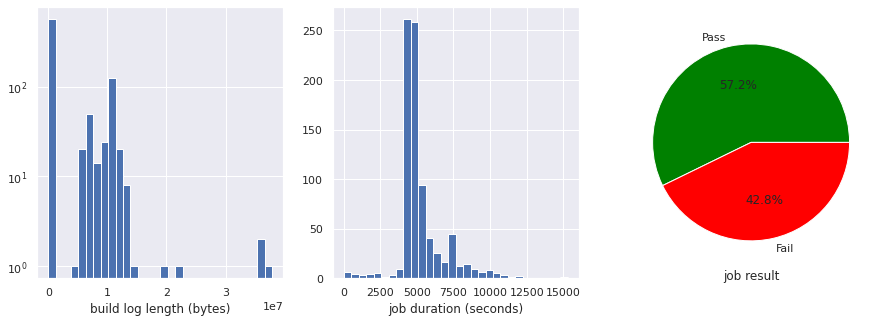

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(df["size"], log=True, bins=30)
axs[0].set_xlabel("build log length (bytes)")
axs[1].hist(df["duration"], bins=30)
axs[1].set_xlabel("job duration (seconds)")
results = [df.success.sum(), (~df.success).sum()]
axs[2].pie(results, autopct="%1.1f%%", labels=["Pass", "Fail"], colors=["green", "red"])
axs[2].set_xlabel("job result")
plt.show()

We can see that the build log sizes go from very short (a few bytes log) to quite long (a few megabytes). By looking at the median (50%) we see that most of them stay on the relatively small side, but the ones that get log do get significantly bigger. Note that the axis for log lenght are in a logarithmic scale, to better accomodate this.

We will find out why by looking at the relationship between the features:

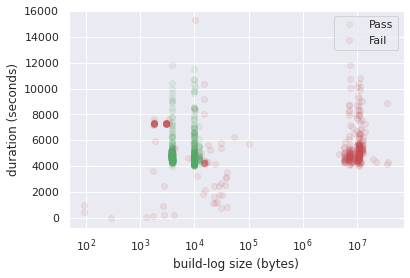

In [8]:
plt.plot("size", "duration", "go", data=df[df.success], alpha=0.1, label="Pass")
plt.plot("size", "duration", "ro", data=df[~df.success], alpha=0.1, label="Fail")
plt.xscale("log")
plt.xlabel("build-log size (bytes)")
plt.ylabel("duration (seconds)")
plt.legend()
plt.show()

Here we can notice a few interesting things:

- There is a strong correlation between a build's `build-log` size and its result.
- Successful job runs have a very consistent build log length.
- A build's duration also has a relationship with the results: a duration under a certain threshold indicates a failure before tests could start, e.g. install or infrastructure issues.

All in all, we can appreciate that it seems to be quite possible to classify build results based on their log size and duration.

## Log samples

Now let's take a look at the contents of the build logs.

### Latest build's head

This is the beginning of the latest build's `build-log.txt`:

In [9]:
print("Build URL:", builds.prow_url_for(builds.latest_build_id), "\n")

path = Builds.log_path_for(builds.latest_build_id)
with open(path) as f:
    lines = f.readlines(2000)

for line in lines:
    print(line, end="")

Build URL: https://prow.ci.openshift.org/view/gcs/origin-ci-test/logs/periodic-ci-openshift-release-master-ci-4.8-e2e-gcp/1387498929158885376 

INFO[2021-04-28T20:08:36Z] ci-operator version v20210428-04f6984        
INFO[2021-04-28T20:08:36Z] Loading configuration from https://config.ci.openshift.org for openshift/release@master [ci-4.8] 
INFO[2021-04-28T20:08:37Z] Resolved SHA missing for master in https://github.com/openshift/release (will prevent caching) 
INFO[2021-04-28T20:08:37Z] Resolved release initial to registry.ci.openshift.org/ocp/release:4.8.0-0.ci-2021-04-27-075557 
INFO[2021-04-28T20:08:37Z] Using explicitly provided pull-spec for release latest (registry.ci.openshift.org/ocp/release:4.8.0-0.ci-2021-04-28-200224) 
INFO[2021-04-28T20:08:37Z] Using namespace https://console.build01.ci.openshift.org/k8s/cluster/projects/ci-op-ptfyqcy5 
INFO[2021-04-28T20:08:37Z] Running [input:origin-centos-8], [input:ocp-4.5-upi-installer], [release:latest], [images], e2e-gcp 
INFO[2021-0

**NOTE**: pretty output with colored log level is a recent addition as of this writing ([PR 1836](https://github.com/openshift/ci-tools/pull/1836), merged 2021-04-05). This change altered the formatting of all build logs (from the change onwards, of course; previous builds' logs have a different format). May this serve as an example of the type of diversity and unexpected output we need to handle.

### Full log of a successful job

When we looked at the metadata, we saw that all the successful builds have a similar lenght. Let's look at one of them:

In [10]:
sample_pass = df[df.success].sample(random_state=1).index.item()

print("Full log of a successful build: ", sample_pass)
print("Build URL:", builds.prow_url_for(sample_pass))
print("Raw log URL:", builds.build_log_url_for(sample_pass), "\n")

path = Builds.log_path_for(sample_pass)
with open(path) as f:
    lines = f.readlines()

for line in lines:
    print(line, end="")

Full log of a successful build:  1378441280396201984
Build URL: https://prow.ci.openshift.org/view/gcs/origin-ci-test/logs/periodic-ci-openshift-release-master-ci-4.8-e2e-gcp/1378441280396201984
Raw log URL: https://storage.googleapis.com/origin-ci-test/logs/periodic-ci-openshift-release-master-ci-4.8-e2e-gcp/1378441280396201984/build-log.txt 

time="2021-04-03T20:16:31Z" level=info msg="ci-operator version v20210402-7d9fcd2"
time="2021-04-03T20:16:31Z" level=info msg="Loading configuration from https://config.ci.openshift.org for openshift/release@master [ci-4.8]"
time="2021-04-03T20:16:31Z" level=info msg="Resolved source https://github.com/openshift/release to master@"
time="2021-04-03T20:16:31Z" level=info msg="Resolved release initial to registry.ci.openshift.org/ocp/release:4.8.0-0.ci-2021-04-02-173758"
time="2021-04-03T20:16:31Z" level=info msg="Using explicitly provided pull-spec for release latest (registry.ci.openshift.org/ocp/release:4.8.0-0.ci-2021-04-03-201542)"
time="2021

Successful jobs tend to have quite similar contents, essentially enumerating the steps that are being followed and reporting their success.

While they are all similar, note the differences in output format, and also format differences within the log file itself.

### Failed job output

When there are failures, the log output of the step that failed is added to the build log. This is why we see the significant differences in log lenghts, and why logs from failed jobs tend to be longer. Or, if the problem occurs during the preparatory steps, we get shorter logs as we saw in the metadata overview.

Let's look at some failed builds' logs. Because these can be huge, we only look at a few lines around the middle of the log file, which is enough to notice that they contain different types of logs than a successful build; they also differ between each other.

**NOTE**: a representative sample was handpicked from builds I had downloaded. To reproduce this, just uncomment the line below that sets `failed_buids` to be a random sample of the data you currently have; re-running the cell a few times should show the diversity of these logs.

In [11]:
# A list of hand-picked represenative build IDs from failed job runs:
failed_builds = [  # Some custom build IDs representing log diversity
    1372555706749685760,  # infra error, short log, long duration, old format
    1380185997530107904,  # same type of error, new formatting
    1375113030177656832,  # mixed output structure
    1383399218122592256,  # new formatting, duplicate and inconsistent timestamps
    1375882831099596800,  # output from a must-gather
]

# No hand pick version: Get a sample of current failed builds
# IMPORTANT NOTE: ------------------------------------------------------------------
# IMPORTANT NOTE: uncomment next line to get a sample from currently available data:
# IMPORTANT NOTE: ------------------------------------------------------------------
# failed_builds = df[~df.success].sample(3).index

for build_id in failed_builds:
    print(f"\n>> BUILD {build_id}")
    print(">> BUILD URL:", builds.prow_url_for(build_id))
    print(">> RAW LOG URL:", builds.build_log_url_for(build_id), "\n")
    path = Builds.log_path_for(build_id)

    with open(path) as f:
        # We will look around the middle of the file
        length = df.loc[build_id]["size"].item()
        f.seek(length / 2)
        lines = f.readlines(2500)

    for line in lines[1:]:
        print(line, end="")


>> BUILD 1372555706749685760
>> BUILD URL: https://prow.ci.openshift.org/view/gcs/origin-ci-test/logs/periodic-ci-openshift-release-master-ci-4.8-e2e-gcp/1372555706749685760
>> RAW LOG URL: https://storage.googleapis.com/origin-ci-test/logs/periodic-ci-openshift-release-master-ci-4.8-e2e-gcp/1372555706749685760/build-log.txt 

2021/03/18 14:29:22 Setting up pipeline imagestream for the test
2021/03/18 14:29:22 Updated secret ci-pull-credentials
2021/03/18 14:29:22 Created secret e2e-gcp-cluster-profile
2021/03/18 14:29:22 Created PDB for pods with openshift.io/build.name label
2021/03/18 14:29:22 Created PDB for pods with created-by-ci label
2021/03/18 14:29:22 Tagging origin/centos:8 into pipeline:origin-centos-8
2021/03/18 14:29:22 Tagging ocp/4.5:upi-installer into pipeline:ocp-4.5-upi-installer
2021/03/18 14:29:22 Importing release image latest
2021/03/18 14:29:23 Executing pod "release-images-latest-cli" running image "release:latest"
2021/03/18 14:29:33 Executing pod "release-im

We can see that the build logs can contain quite diverse content, including multi-line command output, entries with partial structure (timestamps, log levels, componets) or completely unsturctured, all of that mixed together in the same log file.

Traditional approaches to automated log parsing would probably not work too well with this type of log data.

# Conclusions

- Failed jobs can contain very diverse types of logs. Different failure causes often lead to different type of content in the logs.
- Successful jobs have significantly more constistent log output.
- Even for successful jobs, we can't assume a consistent structure.
- It should be relatively easy to classify builds from their duration and `build-log` lenght, but can we do the same based on the content of the logs?

## Next steps

- Look at specific steps instead of the overall job build log. The expectation would be that by looking at the same step we would get more consistency across job runs, both successful and failed.

- More detailed exploration of the log contents by applying different techniques to log files themselves.
